In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
from springstone.data import get_data, add_missing_days, create_train_test, drop_nan, subsample_sequence, get_X_y
from springstone.utils import bollinger_bands, moving_average, daily_return
from springstone.encoders import TimeFeaturesEncoder, BollingerBandsTransformer, MovingAverageTransformer, DailyReturnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MAPE, MAE
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config; set_config(display='diagram')
import keras_tuner as kt
import joblib

# Get the original data set for the AAPL ticker and preprocess it

## Get the data from Yahoo Finance

In [4]:
hist_aapl = get_data('AAPL', end='2022-03-11')

[*********************100%***********************]  1 of 1 completed


In [5]:
hist_aapl.shape

(2531, 5)

## Split the data into a train and test set

In [6]:
df_train, df_test = create_train_test(hist_aapl)
print(df_train.shape, df_test.shape)

(2025, 5) (506, 5)


## Pipeline to clean the data, add the engineered features and transform it to be ingested by a RNN model

In [7]:
# Parallelize "fin scaler" and "One hot encoder"
transform = ColumnTransformer([('fin_scaller', StandardScaler(), ['Open', 'Close', 'Volume', 'Close_bb20_2', 'Close_bb20_-2', 'Close_ma7', 'Close_percentage_change']),
                               ('onehotencode_time_features', OneHotEncoder(drop='if_binary', sparse=False, handle_unknown='ignore'), ['dow', 'month'])],
                               remainder='drop')

# preprocessor
preprocessor = Pipeline([('add_missing_days', FunctionTransformer(add_missing_days)),
                         ('add_Close_bb20_2', BollingerBandsTransformer()),
                         ('add_Close_bb20_-2', BollingerBandsTransformer(standard_deviations=-2)),
                         ('add_Close_ma7', MovingAverageTransformer()),
                         ('add_Close_percentage_change', DailyReturnTransformer()),
                         ('add_time_features', TimeFeaturesEncoder()),
                         ('drop_nan', FunctionTransformer(drop_nan)),
                         ('transform', transform)])
preprocessor

Pipeline(steps=[('add_missing_days',
                 FunctionTransformer(func=<function add_missing_days at 0x7f57033c4e50>)),
                ('add_Close_bb20_2', BollingerBandsTransformer()),
                ('add_Close_bb20_-2',
                 BollingerBandsTransformer(standard_deviations=-2)),
                ('add_Close_ma7', MovingAverageTransformer()),
                ('add_Close_percentage_change', DailyReturnTransformer()),
                ('add_time_features',...
                 FunctionTransformer(func=<function drop_nan at 0x7f57033c4ee0>)),
                ('transform',
                 ColumnTransformer(transformers=[('fin_scaller',
                                                  StandardScaler(),
                                                  ['Open', 'Close', 'Volume',
                                                   'Close_bb20_2',
                                                   'Close_bb20_-2', 'Close_ma7',
                                                   'Close_percentage_change']),
                                                 ('onehotencode_time_features',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['dow', 'month'])]))])

In [8]:
preprocessor.fit(df_train)
df_train = preprocessor.transform(df_train)
df_test = preprocessor.transform(df_test)

In [9]:
print(df_train.shape, df_test.shape)

(2921, 26) (712, 26)


# Additional required data preprocessing for a RNN model with only 1 sequence (1 ticker)

## Generate random train and test samples of random length of the ticker sequence  

In [35]:
length_of_observations = np.random.randint(7, 15, 2000)
X_train, y_train = get_X_y(df_train, 1, length_of_observations)
length_of_observations = np.random.randint(7, 15, 500)
X_test, y_test = get_X_y(df_test, 1, length_of_observations)

## Pad the train and test samples to the same number of observations

In [36]:
X_train_pad = pad_sequences(X_train, dtype='float32', padding='post', value=-1000)
X_test_pad = pad_sequences(X_test, dtype='float32', padding='post', value=-1000)

In [37]:
X_train_pad.shape

(2000, 14, 26)

In [38]:
y_train.shape

(2000,)

# RNN model

In [39]:
model = Sequential([
                    Masking(mask_value=-1000, input_shape=X_train_pad[0].shape),
                    GRU(units=20, activation='tanh', return_sequences= True),
                    GRU(units=20, activation='tanh', return_sequences= False),
                    Dense(units=50, activation='relu'),
                    Dropout(0.2),
                    Dense(1, activation='linear')
                    ])
model.compile(loss='mse', optimizer=RMSprop(learning_rate=0.001), metrics=[MAPE, MAE])

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 14, 26)            0         
                                                                 
 gru_4 (GRU)                 (None, 14, 20)            2880      
                                                                 
 gru_5 (GRU)                 (None, 20)                2520      
                                                                 
 dense_4 (Dense)             (None, 50)                1050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 6,501
Trainable params: 6,501
Non-traina

In [41]:
es = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train_pad, y_train, batch_size = 64, epochs=1500, verbose=0, validation_split=0.2, callbacks=[es])

In [46]:
joblib.dump(model, 'model_rnn_AAPL.joblib')

2022-03-10 13:36:59.122597: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://7562d80e-2203-4637-a0b6-0e47bbd8b39d/assets


INFO:tensorflow:Assets written to: ram://7562d80e-2203-4637-a0b6-0e47bbd8b39d/assets


['model_rnn_AAPL.joblib']

## Model definition and compilation

In [ ]:
def model_builder(hp):
    # Tune the number of units in the rnn layers
    # Choose an optimal value between 5-40
    hp_RNN_units = hp.Int('RNN_units', min_value=5, max_value=40, step=5)
    # Tune the number of units in the first dense layer
    # Choose an optimal value between 5-70
    hp_dense1_units = hp.Int('dense1_units', min_value=5, max_value=70, step=5)
    model = Sequential([
                        Masking(mask_value=-1000, input_shape=X_train_pad[0].shape),
                        GRU(units=hp_RNN_units, activation='tanh', return_sequences= True),
                        GRU(units=hp_RNN_units, activation='tanh', return_sequences= False),
                        Dense(units=hp_dense1_units, activation='relu'),
                        Dropout(0.2),
                        Dense(1, activation='linear')
                        ])
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.005, 0.001, 0.0005 or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 0.005, 1e-3, 0.0005, 1e-4])
    model.compile(loss='mse', optimizer=RMSprop(learning_rate=hp_learning_rate), metrics=[MAPE, MAE])
    return model

## Instantiate the tuner and perform hypertuning

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=1500,
                     factor=3,
                     directory='blue_dir',
                     project_name='springstone')

In [ ]:
es = EarlyStopping(patience=10, restore_best_weights=True)
tuner.search(X_train_pad, y_train, batch_size = 64, epochs=1000, validation_split=0.2, callbacks=[es], verbose=0)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the rnn
layers is {best_hps.get('RNN_units')}, in the dense1 layer is {best_hps.get('dense1_units')}
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


## Model training

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_pad, y_train, batch_size = 64, epochs=1500, verbose=0, validation_split=0.2, callbacks=[es])

## Model evaluation

In [16]:
def plot_history(history, title=None):
    fig, ax = plt.subplots(1,3, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,0.2))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- MAE
    
    ax[1].plot(history.history['mean_absolute_error'])
    ax[1].plot(history.history['val_mean_absolute_error'])
    ax[1].set_title('Model MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,0.3))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    # --- MAPE
    
    ax[2].plot(history.history['mean_absolute_percentage_error'])
    ax[2].plot(history.history['val_mean_absolute_percentage_error'])
    ax[2].set_title('Model MAPE')
    ax[2].set_ylabel('MAPE')
    ax[2].set_xlabel('Epoch')
    ax[2].legend(['Train', 'Test'], loc='best')
    ax[2].set_ylim((0,100))
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    

    if title:
        fig.suptitle(title)

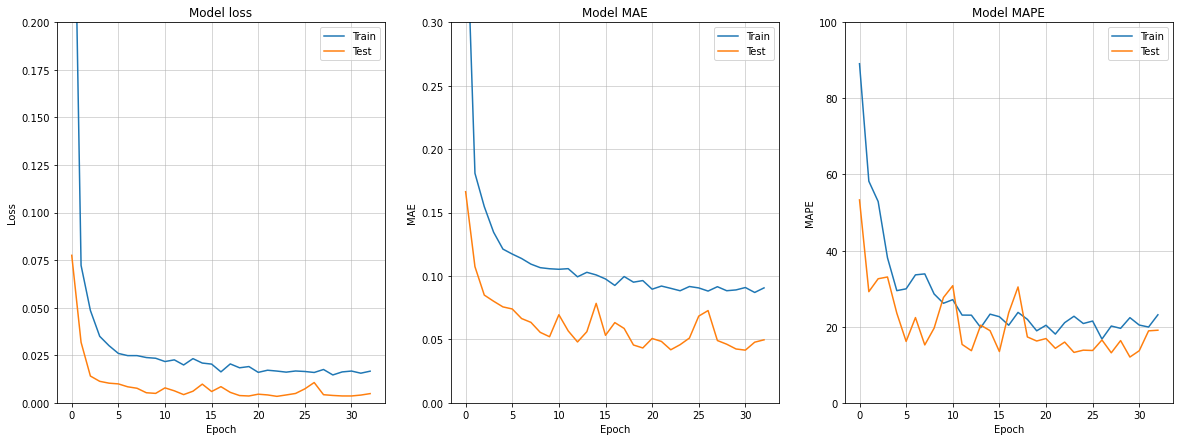

In [42]:
plot_history(history)

In [43]:
model.evaluate(X_test_pad, y_test)

16/16 [==============================] - 0s 7ms/step - loss: 10.7583 - mean_absolute_percentage_error: 38.2051 - mean_absolute_error: 2.8515


[10.758321762084961, 38.20512008666992, 2.8514866828918457]